In [ ]:
from pyhive import presto
from sqlalchemy import create_engine
from string import Template

class DataHandler:

    def __init__(self, params):
        self.params = params
        self.market = params['market']
        self.cnxn = self.connect_to_presto()
        self.engine = create_engine(f"presto://presto-{self.market}.taxibeat.com:8080/")

    def connect_to_presto(self):
        """
        Function to initialize connection with Presto database
        """
        try:
            cnxn = presto.connect(host=f"presto-{self.market}.taxibeat.com", port=8080)
        except presto.DatabaseError as err:
            print(f"Error: Could not make connection to Presto DB: {err}")
        return cnxn

    def execute_query(self, query):
        df = pd.read_sql_query(query, self.cnxn)
        return df
    
    def read_query(self, path):
        with open(path, "r") as f:
            query = f.read()
        return query
    
    def transform_query(self, query):
        query = Template(query)
        transformed_query = query.substitute(self.params)
        return transformed_query

    def drop_table(self, table_name):
        query = f"DROP TABLE IF EXISTS {table_name}"
        pd.read_sql_query(query, self.cnxn)

    def store_data(self, table_name, df, mode='replace'):
        df.to_sql(
            name=table_name,
            con=self.engine,
            if_exists=mode,
            index=False,
            chunksize=10000,
            method='multi'
        )
        
        
params={"country": "colombia",
        "market": "co"}

d = DataHandler(params)

df = d.execute_query(""" select * from
co.dna.underestimated_rides_raw_level_data limit 2000000
""")

In [1]:
def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].unique(), 0)}

def integer_encode(df, variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)
    
def calculate_top_categories(df, variable, n=10):
    return [x for x in df[variable].value_counts().sort_values(ascending=False).head(n).index]

def one_hot_encode(df, variable, top_labels):
    for label in top_labels:
        df[variable + '_' + label] = np.where(df[variable] == label, 1, 0)
        
def frequency_encoding(df,variable):
    count_map = df[variable].value_counts().to_dict()
    df[variable + '_' + 'freq_encoding'] = df[variable].map(count_map) / len(df)
    
def find_freq_labels(data, variable, upper_tolerance, lower_tolerance):
    
    temp = data.groupby([variable])[variable].count() / len(data)
    
    high_freq = [x for x in temp.loc[temp>upper_tolerance].index.values]
    med_freq = [x for x in temp.loc[(temp>lower_tolerance) & (temp<upper_tolerance)].index.values]
    rare_freq = [x for x in temp.loc[temp<lower_tolerance].index.values]
    
    return high_freq, med_freq, rare_freq

def discretize(data, var, num_of_bins):
    disc, intervals = pd.qcut(
    data[var], num_of_bins, labels=['Q'+str(i) for i in range(1,num_of_bins+1)], 
    retbins=True, precision=3, duplicates='raise')

    data[var+'_discretized'] = disc
    
def remove_outlier(df, col_name, multiplier=1.5):
    q1 = df[col_name].quantile(0.1)
    q3 = df[col_name].quantile(0.9)
    iqr = q3 - q1 #Interquartile Range
    low_bound  = q1 - multiplier * iqr
    high_bound = q3 + multiplier * iqr
    df_out = df.loc[(df[col_name] > low_bound) & (df[col_name] < high_bound)]
    
    return df_out

def stratify_data(df_data, stratify_column_name, stratify_values, stratify_proportions, random_state=None):
    """Stratifies data according to the values and proportions passed in
    Args:
        df_data (DataFrame): source data
        stratify_column_name (str): The name of the single column in the dataframe that holds the data values that will be used           to stratify the data
        stratify_values (list of str): A list of all of the potential values for stratifying e.g. "Train, Validate", "Test"
        stratify_proportions (list of float): A list of numbers representing the desired propotions for stratifying e.g. 0.4,             0.4, 0.2. The list values must add up to 1 and must match the number of values in stratify_values
        random_state (int, optional): sets the random_state. Defaults to None.
    Returns:
        DataFrame: a new dataframe based on df_data that has the new proportions represnting the desired strategy for stratifying
    """
    df_stratified = pd.DataFrame(columns = df_data.columns) # Create an empty DataFrame with column names matching df_data
    pos = -1
    for i in range(len(stratify_values)): # iterate over the stratify values (e.g. Train, Validate, Test)
        pos += 1
        if pos == len(stratify_values) - 1:
            ratio_len = len(df_data) - len(df_stratified) # if this is the final iteration make sure we calculate the number of values for the last set such that the return data has the same number of rows as the source data
        else:
            ratio_len = int(len(df_data) * stratify_proportions[i]) # Calculate the number of rows to match the desired proportion
        df_filtered = df_data[df_data[stratify_column_name] ==stratify_values[i]] # Filter the source data based on the currently selected stratify value
        df_temp = df_filtered.sample(replace=True, n=ratio_len, random_state=random_state) # Sample the filtered data using the calculated ratio
        df_stratified = pd.concat([df_stratified, df_temp]) # Add the sampled / stratified datasets together to produce the final result
    
    return df_stratified # Return the stratified, re-sampled data

def equal_sampling (data, col, randomstate):
    k = data[col].value_counts().min()
    df = data.groupby(col).apply(lambda x: x.sample(k,random_state=randomstate)) 
    df.index = df.index.droplevel(0)
    
    return df

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import timedelta

import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
#df.to_csv('distanceestimation_co_2.csv')
df = pd.read_csv('distanceestimation_co_2.csv').sort_values('created_local')
df.distance_actual = df.distance_actual / 1000
del df['Unnamed: 0']

In [4]:
df = df[df.distance_actual>1]

In [5]:
df['timestamp'] = pd.to_datetime(df.created_local)
df['date'] = pd.to_datetime(df.created_local).dt.date
df['time'] = pd.to_datetime(df.created_local).dt.time

df['hour'] = pd.to_datetime(df.created_local).dt.hour.astype(str)
df['minute'] = pd.to_datetime(df.created_local).dt.minute

df['weekday'] = pd.to_datetime(df.date).dt.weekday
df['dur_per_dist'] = df.estimate_duration/df.distance_est # Known value at the moment 
df['dur_error'] = df.actual_duration_s/df.estimate_duration - 1
df['dist_error'] = df.distance_actual/df.distance_est - 1

In [6]:
df.columns

Index(['created_local', 'id_city', 'id_ride', 'id_driver', 'actual_duration_s',
       'estimate_duration', 'distance_actual', 'distance_est', 'base_fare',
       'service', 'surge_level', 'from_zone', 'to_zone', 'pickup_eta',
       'estimated_eta', 'timestamp', 'date', 'time', 'hour', 'minute',
       'weekday', 'dur_per_dist', 'dur_error', 'dist_error'],
      dtype='object')

In [7]:
df.hour.astype(str)

1384264     0
1108178     0
1598940     0
1384156     0
307819      0
           ..
738863     18
1722993    18
1680954    18
1743205    18
1929241    18
Name: hour, Length: 1960139, dtype: object

In [8]:
# Create the categorical variable
df['OnD'] = df.from_zone.astype('str') + '_' + df.to_zone.astype('str')
frequency_encoding(df,'OnD')
#discretize(df,'OnD_freq_encoding',20)

#df['origin'] = df.from_zone.astype('str')
#df['destination'] = df.to_zone.astype('str')
#frequency_encoding(df,'origin')
#frequency_encoding(df,'destination')

frequency_encoding(df,'id_driver')

one_hot_encode(df,'service',df.service.unique())
one_hot_encode(df,'hour',df.hour.unique())

In [9]:
df

,created_local,id_city,id_ride,id_driver,actual_duration_s,estimate_duration,distance_actual,distance_est,base_fare,service,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
1384264,2022-03-01 00:00:08.000,3,154094913,1624663,491,693,6.369902,6.82,8700.0,Beat,...,0,0,0,0,0,0,0,0,0,0
1108178,2022-03-01 00:00:19.000,1,154094916,230210,1243,1042,13.614501,13.57,13600.0,Beat,...,0,0,0,0,0,0,0,0,0,0
1598940,2022-03-01 00:00:28.000,1,154094918,114767,826,852,7.905441,7.92,9100.0,Beat,...,0,0,0,0,0,0,0,0,0,0
1384156,2022-03-01 00:00:35.000,1,154094919,1641380,274,272,1.480884,1.87,4400.0,Beat,...,0,0,0,0,0,0,0,0,0,0
307819,2022-03-01 00:00:41.000,2,154094921,1636890,600,428,3.764977,3.87,6800.0,Lite,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738863,2022-06-30 18:55:04.000,1,163475149,1211233,1160,889,3.901726,3.92,8000.0,Beat,...,0,0,0,0,1,0,0,0,0,0
1722993,2022-06-30 18:55:48.000,1,163475188,1220700,539,448,1.879935,1.85,5400.0,Beat,...,0,0,0,0,1,0,0,0,0,0
1680954,2022-06-30 18:55:52.000,1,163475193,934781,592,457,1.451683,1.55,5100.0,Beat,...,0,0,0,0,1,0,0,0,0,0
1743205,2022-06-30 18:57:51.000,4,163475336,381909,555,440,3.106130,2.17,5600.0,Beat,...,0,0,0,0,1,0,0,0,0,0


In [10]:
#df['timestamp_shift'] = df['timestamp'].shift(-1)
#df['time_delta'] = (df.timestamp_shift - df.timestamp) / pd.Timedelta(minutes=1)
#del df['timestamp_shift']

In [11]:
## TARGET VARIABLE

df['under_est_dur'] = np.where(df.dur_error > 0.2, 1, 0)
#df['under_est_dist'] = np.where(df.dist_error > 0.3, 1, 0)

### Get the last target values for drivers OnDs and Destinations

In [12]:
## For the Drivers

last_drv_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('id_driver', keep='last')\
                   [['id_driver','under_est_dur']]
df = df.merge(last_drv_target.set_index('id_driver'),on='id_driver',suffixes=(None,'_drv_last'))

## For the OnDs

last_ond_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('OnD', keep='last')\
                   [['OnD','under_est_dur']]
df = df.merge(last_ond_target.set_index('OnD'),on='OnD',suffixes=(None,'_ond_last'))

## For the Destinations

last_dest_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('to_zone', keep='last')\
                   [['to_zone','under_est_dur']]
df = df.merge(last_dest_target.set_index('to_zone'),on='to_zone',suffixes=(None,'_dest_last'))

## For the Origins

last_orig_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('from_zone', keep='last')\
                   [['from_zone','under_est_dur']]
df = df.merge(last_orig_target.set_index('from_zone'),on='from_zone',suffixes=(None,'_orig_last'))

In [13]:
df[df.under_est_dur!=df.under_est_dur_drv_last][['under_est_dur','under_est_dur_drv_last']]

,under_est_dur,under_est_dur_drv_last
4,0,1.0
8,1,0.0
11,1,0.0
13,0,1.0
15,0,1.0
...,...,...
1960115,1,0.0
1960129,0,1.0
1960133,0,1.0
1960135,0,1.0


In [14]:
df[df.under_est_dur!=df.under_est_dur_ond_last][['under_est_dur','under_est_dur_ond_last']]

,under_est_dur,under_est_dur_ond_last
0,0,1.0
1,0,1.0
2,0,1.0
3,0,1.0
4,0,1.0
...,...,...
1960096,1,0.0
1960104,1,0.0
1960129,0,1.0
1960134,1,0.0


In [15]:
df#[columns_to_exclude]

,created_local,id_city,id_ride,id_driver,actual_duration_s,estimate_duration,distance_actual,distance_est,base_fare,service,...,hour_19,hour_20,hour_21,hour_22,hour_23,under_est_dur,under_est_dur_drv_last,under_est_dur_ond_last,under_est_dur_dest_last,under_est_dur_orig_last
0,2022-03-01 00:00:08.000,3,154094913,1624663,491,693,6.369902,6.82,8700.0,Beat,...,0,0,0,0,0,0,0.0,1.0,0.0,1.0
1,2022-03-14 16:20:57.000,3,155244827,1647750,1735,1669,9.300710,9.40,13100.0,Beat,...,0,0,0,0,0,0,0.0,1.0,0.0,1.0
2,2022-06-13 19:41:13.000,3,162255330,486855,1124,1068,8.891921,8.17,10900.0,Beat,...,1,0,0,0,0,0,0.0,1.0,0.0,1.0
3,2022-06-06 09:33:44.000,3,161678873,359469,1638,1412,9.996283,8.29,10500.0,Beat,...,0,0,0,0,0,0,0.0,1.0,0.0,1.0
4,2022-03-14 17:17:14.000,3,155249452,379324,1366,1250,6.565516,6.53,10000.0,Beat,...,0,0,0,0,0,0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960134,2022-03-14 11:38:05.000,4,155224751,867614,1844,1476,11.536468,11.03,15100.0,Beat,...,0,0,0,0,0,1,1.0,0.0,0.0,0.0
1960135,2022-06-14 09:45:15.000,4,162282475,1430989,1654,1489,10.660644,11.00,13500.0,Beat,...,0,0,0,0,0,0,1.0,0.0,0.0,0.0
1960136,2022-03-06 09:04:43.000,2,154568712,1648237,2800,1802,15.099739,15.19,18600.0,Beat,...,0,0,0,0,0,1,1.0,1.0,0.0,1.0
1960137,2022-03-07 22:32:17.000,4,154701954,1508319,173,285,1.278699,2.34,5500.0,Beat,...,0,0,0,1,0,0,0.0,1.0,1.0,1.0


In [16]:
df.columns

Index(['created_local', 'id_city', 'id_ride', 'id_driver', 'actual_duration_s',
       'estimate_duration', 'distance_actual', 'distance_est', 'base_fare',
       'service', 'surge_level', 'from_zone', 'to_zone', 'pickup_eta',
       'estimated_eta', 'timestamp', 'date', 'time', 'hour', 'minute',
       'weekday', 'dur_per_dist', 'dur_error', 'dist_error', 'OnD',
       'OnD_freq_encoding', 'id_driver_freq_encoding', 'service_Beat',
       'service_Lite', 'service_Pronto', 'service_Envío', 'service_Plus',
       'service_Zero', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'under_est_dur', 'under_est_dur_drv_last', 'under_est_dur_ond_last',
       'under_est_dur_dest_last', 'under_est_dur_orig_last'],
      dtype='object')

In [17]:
db = remove_outlier(df,'distance_actual')

In [18]:
db.columns

Index(['created_local', 'id_city', 'id_ride', 'id_driver', 'actual_duration_s',
       'estimate_duration', 'distance_actual', 'distance_est', 'base_fare',
       'service', 'surge_level', 'from_zone', 'to_zone', 'pickup_eta',
       'estimated_eta', 'timestamp', 'date', 'time', 'hour', 'minute',
       'weekday', 'dur_per_dist', 'dur_error', 'dist_error', 'OnD',
       'OnD_freq_encoding', 'id_driver_freq_encoding', 'service_Beat',
       'service_Lite', 'service_Pronto', 'service_Envío', 'service_Plus',
       'service_Zero', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'under_est_dur', 'under_est_dur_drv_last', 'under_est_dur_ond_last',
       'under_est_dur_dest_last', 'under_est_dur_orig_last'],
      dtype='object')

In [19]:
columns_to_exclude = ['created_local','id_ride', 'id_driver','actual_duration_s','distance_actual',
                      'distance_est','service','dur_error','dist_error','date','timestamp','time','OnD',
                      'from_zone','to_zone','date',
                      'OnD_freq_encoding','id_driver_freq_encoding','under_est_dur_drv_last',
                      'under_est_dur_ond_last', 'under_est_dur_dest_last','under_est_dur_orig_last','hour']

In [20]:
db = remove_outlier(db,'dur_per_dist')
db = db.replace([np.inf, -np.inf], np.nan).dropna()
db = db.drop(columns=columns_to_exclude).dropna()

In [21]:
#top_comb_drv = calculate_top_categories(df, 'id_driver', n=30)
#[str(x) for x in top_comb_drv]
#one_hot_encode(df, 'id_driver', [str(x) for x in top_comb_drv])

# Top-n OnD iteneraries (OnD)
#top_comb_ond = calculate_top_categories(df, 'OnD', n=70)
# One-Hot-Encoding the top-20 OnDs
#one_hot_encode(df, 'OnD', top_comb_ond)

In [22]:
#filter_col = [col for col in df if col.startswith('id_driver_')]

In [23]:
X = db.drop(['under_est_dur'],axis=1)
y = db.under_est_dur

# Forcing equal ratio on the binary variable
X_y = equal_sampling(data=pd.concat([X,y],axis=1), col='under_est_dur', randomstate=23)

X_eq = X_y.drop(['under_est_dur'],axis=1)
y_eq = X_y['under_est_dur']

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=23)

# Forcing equal ratio on the binary variable
X_train, X_test, y_train, y_test = train_test_split(X_eq, y_eq, test_size=0.25,random_state=23)

In [25]:
db.under_est_dur.value_counts(normalize=True)

0    0.705168
1    0.294832
Name: under_est_dur, dtype: float64

In [26]:
y_train.value_counts(normalize=True)

1    0.500302
0    0.499698
Name: under_est_dur, dtype: float64

In [27]:
y_test.value_counts(normalize=True)

0    0.500906
1    0.499094
Name: under_est_dur, dtype: float64

In [28]:
X_train.isnull().sum()
X_train.columns#.describe()

Index(['id_city', 'estimate_duration', 'base_fare', 'surge_level',
       'pickup_eta', 'estimated_eta', 'minute', 'weekday', 'dur_per_dist',
       'service_Beat', 'service_Lite', 'service_Pronto', 'service_Envío',
       'service_Plus', 'service_Zero', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'],
      dtype='object')

In [29]:
# Models

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost.sklearn import XGBClassifier

# Evaluation Metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

models = []

#models.append(('LR', LogisticRegression(solver='liblinear')))
#models.append(('Rdg', RidgeClassifier()))
#models.append(('SVC', SVC()))
#models.append(('GNB', GaussianNB()))
#models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
#models.append(('ADA', AdaBoostClassifier()))
#models.append(('GB', GradientBoostingClassifier()))
#models.append(('QDA', QuadraticDiscriminantAnalysis()))
#models.append(('KNC', KNeighborsClassifier()))
models.append(('XGB', XGBClassifier()))

names, acc_scores, recall_scores, f1_scores = [], [], [], []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    names.append(name)
    
tr_split = pd.DataFrame({'Model': names, 'Accuracy Score': acc_scores, 
                         'Recall Score': recall_scores, 'F1 Score': f1_scores})
tr_split

,Model,Accuracy Score,Recall Score,F1 Score
0,RF,0.577046,0.540837,0.560709
1,XGB,0.582313,0.507723,0.548198


### Picking some Models

In [30]:
dt = DecisionTreeClassifier(criterion='entropy',
                            splitter='best',
                            max_depth=None,
                            min_samples_leaf=0.05,
                            max_features=None,
                            random_state=23)

dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)
print('Accuracy of the classifier on test set: {:.2f}'.format(dt.score(X_test, y_test)))

Accuracy of the classifier on test set: 0.56


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56    139114
           1       0.56      0.56      0.56    138611

    accuracy                           0.56    277725
   macro avg       0.56      0.56      0.56    277725
weighted avg       0.56      0.56      0.56    277725



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


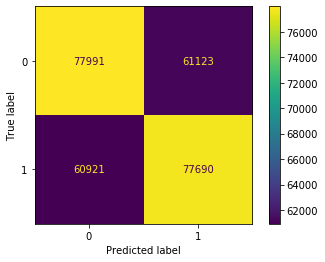

In [32]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plot_confusion_matrix(dt, X_test, y_test, values_format='')  
plt.show()

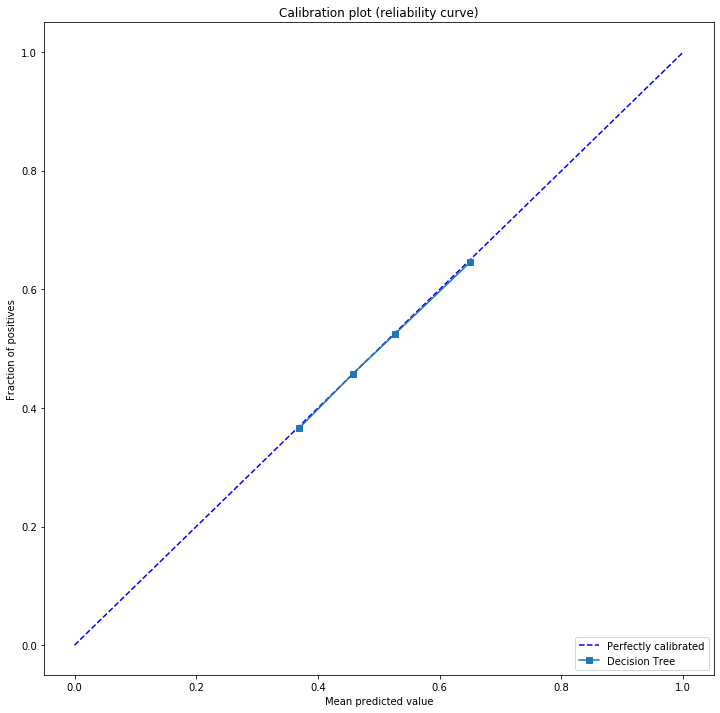

In [33]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

prob_pos_dt = dt.predict_proba(X_test)[:, 1]
fraction_of_positives_dt, mean_predicted_value_dt = calibration_curve(y_test, prob_pos_dt, n_bins=10)
ax.plot(mean_predicted_value_dt, fraction_of_positives_dt, "s-", label="%s" % ('Decision Tree'))

ax.legend(loc="lower right")
plt.show()

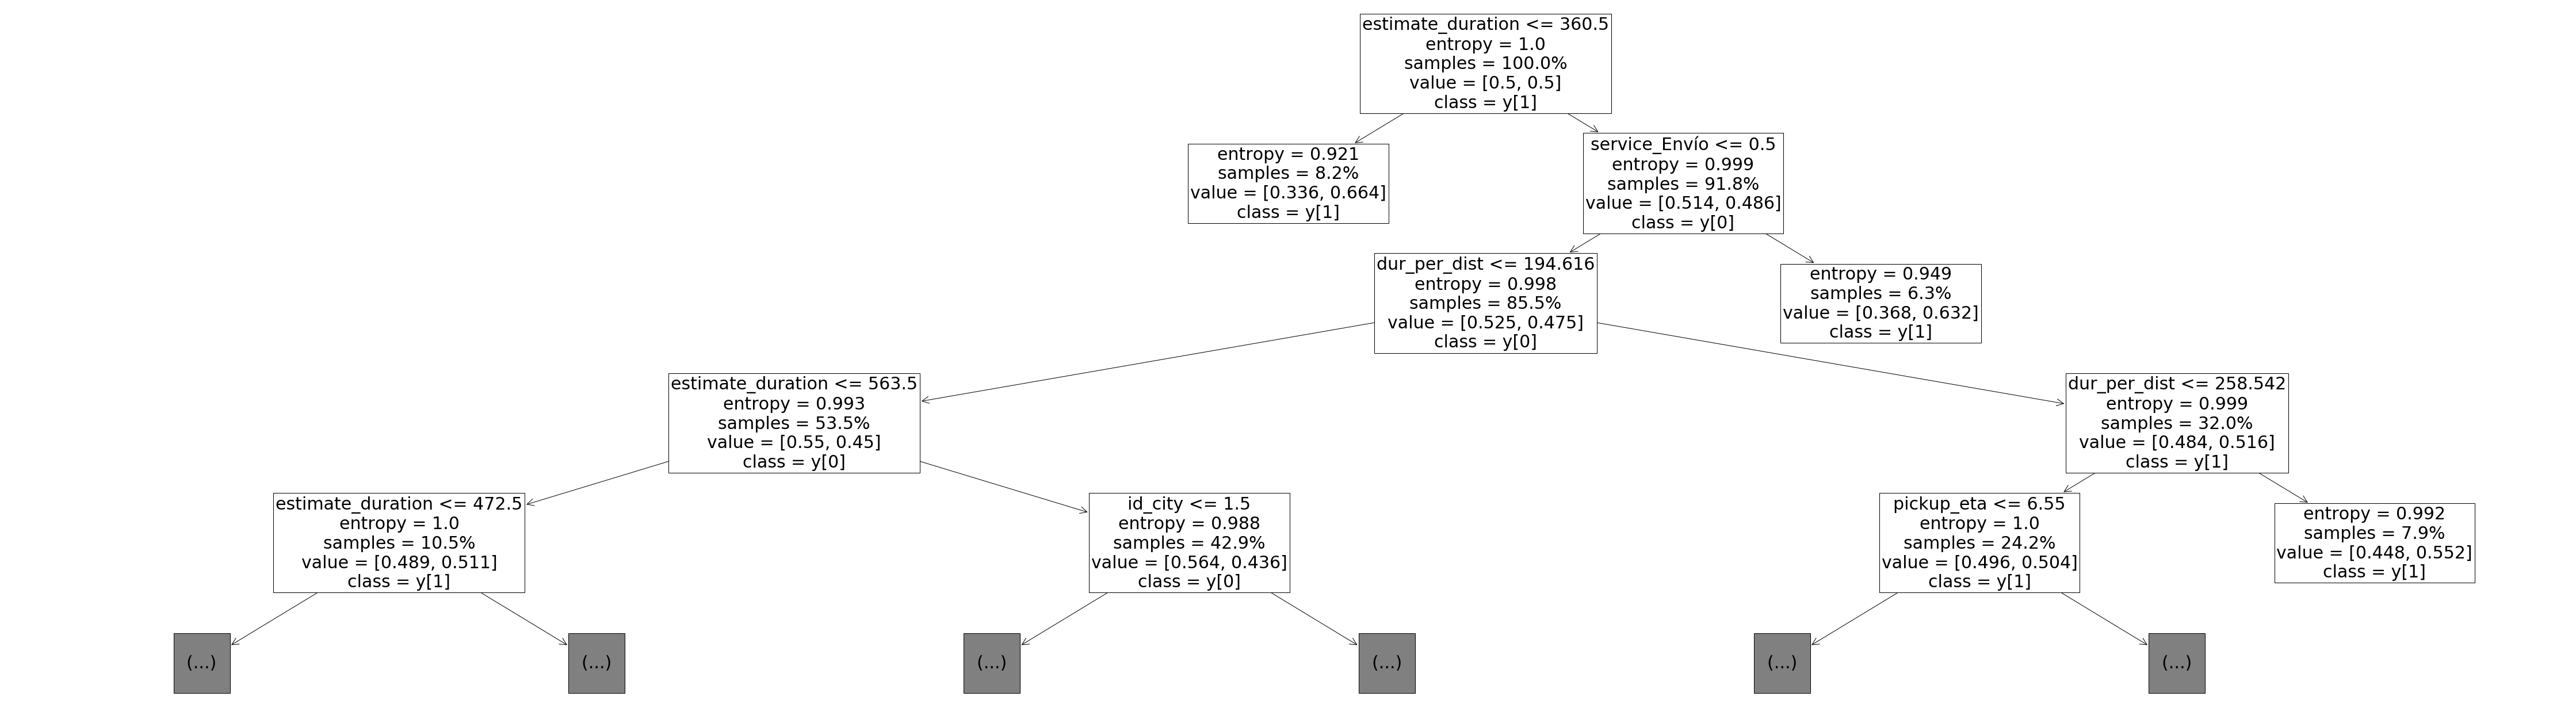

In [34]:
from sklearn import tree

plt.figure(figsize=(80,23))
tree.plot_tree(dt,max_depth=4,feature_names=X_test.columns,class_names=True,proportion=True,fontsize=30)
plt.show()

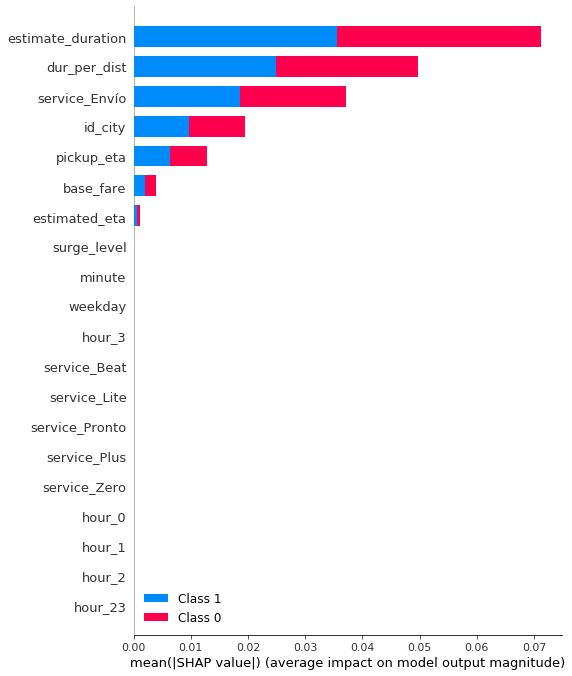

In [35]:
import shap
explainer = shap.TreeExplainer(dt)
shap_values_dt = explainer.shap_values(X_test)
shap.summary_plot(shap_values_dt, X_train, plot_type="bar")

In [ ]:
clf_pruned = DecisionTreeClassifier(criterion = "gini", random_state = 23,
                                    max_depth=3, min_samples_leaf=5)
clf_pruned.fit(X_train, y_train)

#visualizing the tree
import io
from io import StringIO
from sklearn.tree import export_graphviz

# from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz

xvar = X_test
feature_cols = X_test.columns
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])

from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
df[df.under_est_dur==1]['id_driver']

In [ ]:
df.groupby('under_est_dur')[['dist_error','distance_actual','actual_duration_s']].median()

In [ ]:
df[df.distance_actual>5].groupby('under_est_dur')[['dist_error','distance_actual','actual_duration_s']].median()

In [ ]:
df[df.distance_actual<5].groupby('under_est_dur')[['dist_error','distance_actual','actual_duration_s']].median()

In [ ]:
X = df[db.columns].drop(['under_est_dur'],axis=1)
y = df.under_est_dur

In [ ]:
# prediction
y_pred = lgbm.predict(X)

cr = classification_report(y, y_pred)
cm = confusion_matrix(y, y_pred)
 
print(cr)
print(cm) 